### Data preparation

In [16]:
import numpy as np
import xarray as xr
import hdc.algo
import rioxarray

from sklearn.model_selection import train_test_split
from hip.analysis.aoi.analysis_area import AnalysisArea

Define area 

In [2]:
BBOX = (28.125,-29.875,41.875,-10.125)

**CHIRPS** 

In [3]:
# Define AnalysisArea
area = AnalysisArea(bbox=BBOX, datetime_range='1981-01-01/2023-12-31')

# Read data and clip to Moz
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])

# Transpose dimensions
rfh = rfh.transpose('latitude', 'longitude', 'time')

# Select 28x28 zone
rfh = rfh.isel(latitude=slice(100, 128), longitude=slice(100, 128))

GDAL_DATA                    = /envs/user/swirl/lib/python3.11/site-packages/rasterio/gdal_data
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


**Forecasts**

In [4]:
# Define AnalysisArea
area = AnalysisArea(bbox=BBOX, resolution=1, datetime_range='1981-01-01/2023-12-31')

# Read issue month forecasts
def read_one_issue_month_forecasts(issue: int):
    da = area.get_dataset(["ECMWF",f"RFH_FORECASTS_SEAS5_ISSUE{issue}_DAILY"]).sel(ensemble=0)
    da = da.where(da.time.dt.month == issue, drop=True)
    return da

da_all_months = xr.concat([read_one_issue_month_forecasts(i) for i in range(1, 13)], dim='time') 

In [5]:
# Select zone
fc = da_all_months.interp(latitude=rfh.latitude, longitude=rfh.longitude, method='nearest')

# Sum by dekad
fc = fc.groupby(fc.time.dekad.start_date).sum()

# Transpose dimensions
fc = fc.transpose('latitude', 'longitude', 'time')

# Drop spatial_ref
fc = fc.drop_vars('spatial_ref')

Harmonize CHIRPS dates

In [6]:
fc = fc.sel(time=rfh.time)

**Combine into a single dataset** 

In [7]:
ds = xr.Dataset({'chirps': rfh, 'ecmwf': fc})

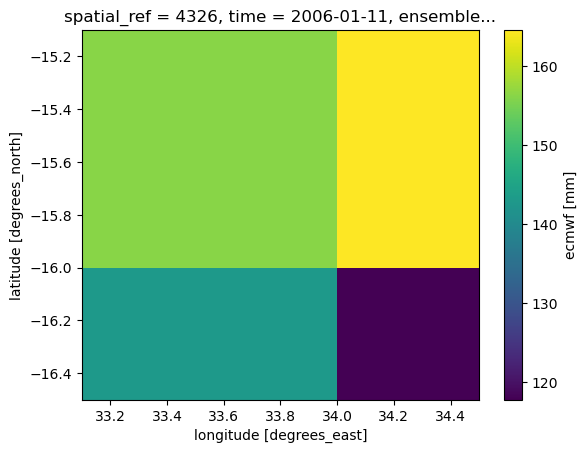

In [10]:
ds.isel(time=901).ecmwf.plot.imshow()

**Filter wet season** 

In [11]:
START_SEASON = 10
END_SEASON = 4

In [28]:
ds.where(ds.time.dt.month.isin((np.arange(START_SEASON-1, END_SEASON+12)%12)+1), drop=True)

<xarray.Dataset> Size: 9MB
Dimensions:      (latitude: 28, longitude: 28, time: 903)
Coordinates:
  * latitude     (latitude) float64 224B -15.13 -15.18 -15.23 ... -16.43 -16.48
  * longitude    (longitude) float64 224B 33.12 33.17 33.23 ... 34.42 34.48
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 7kB 1981-01-01 1981-01-11 ... 2023-12-21
    ensemble     int64 8B 0
Data variables:
    chirps       (latitude, longitude, time) float64 6MB dask.array<chunksize=(28, 28, 1), meta=np.ndarray>
    ecmwf        (latitude, longitude, time) float32 3MB dask.array<chunksize=(28, 28, 1), meta=np.ndarray>

**Split train / test sets**

In [29]:
# Split train and test
train_dates, test_dates = train_test_split(ds.time, test_size=0.25, shuffle=False, random_state=888)

ds_train = ds.sel(time=train_dates)
ds_test = ds.sel(time=test_dates)

In [31]:
# Save train data
_ = [ds_train.isel(time=slice(t,t+1)).to_zarr(f"data/train/smallarea28moztime{t}.zarr") for t in range(ds_train.time.size)]

In [32]:
# Save test data
_ = [ds_test.isel(time=slice(t,t+1)).to_zarr(f"data/test/smallarea28moztime{t}.zarr") for t in range(ds_test.time.size)]